# Detecting and Categorizing Brick Kilns from Satellite Imagery
> * 🔬 Data Science
* 🥠 Deep Learning and Object Detection

## Table of Contents
* [Introduction](#Introduction)
* [Export Training Data](#Export-Training-Data)
* [Train the Model](#Train-the-Model)
 * [Load an SingleShotDetector model](#Load-an-SingleShotDetector-model)
 * [Find an Optimal Learning Rate](#Find-an-Optimal-Learning-Rate)
 * [Fit the model](#Fit-the-model)
 * [Save the model](#Save-the-model)
 * [Visualize results in validation set](#Visualize-results-in-validation-set)
* [Deploy Model and Detect Brick Kilns](#Deploy-Model-and-Detect-Brick-Kilns)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction
With rapid urbanization the demand for bricks is increasing and brick production is a very large and traditional industry in many parts of Asia. The brick sector in India, although unorganized, is tremendous in size. India is the second largest producer of bricks (China dominates with 54% share) in the world [1].

Brick kilns are a major contributor in air pollution, the production of bricks leads to emission of harmful gases including toxic elements that contain particulate matters rich in rich in carbon particles and high concentration of carbon monoxides and oxides of Sulphur (SOx). Exposure to these emissions is extremely hazardous to health and can impact physical and mental growth of children.

There are several guidelines and directives issued by Govt. of India in order to control unplanned expansion and pollution. Central Pollution Control Board (CPCB) issued a directive in June 2017 mandating brick kilns across India to convert to a less polluting zigzag setting with rectangular kiln shape. This directive clearly stated that brick kilns operating without permission and consent from respective SPCBs would be shut down [2]. Despite the directive, there are many brick kilns still operating without following the design norms as prescribed by CPCB.

In this sample, we will use Deep Learning on ArcGIS Platform to detect the location and design category of all brick kilns around Delhi NCR area in India to find the brick kilns which are not following the directions from CPCB. Deep Learning is a tried and tested method for object detection on satellite imagery and high level steps that we will follow are:

* Collect Data using ArcGIS Pro
* Train Deep Learning model using arcgis.learn
* Deploy the trained model using ArcGIS Pro


>We will be using ESRI World Imagery basemap layer to train the model, and for a comparative analysis we will also be using a [ESRI World Imagery basemap layer from year 2014](https://www.arcgis.com/home/item.html?id=903f0abe9c3b452dafe1ca5b8dd858b9) which we found using the [wayback imagery tool](https://livingatlas.arcgis.com/wayback/).


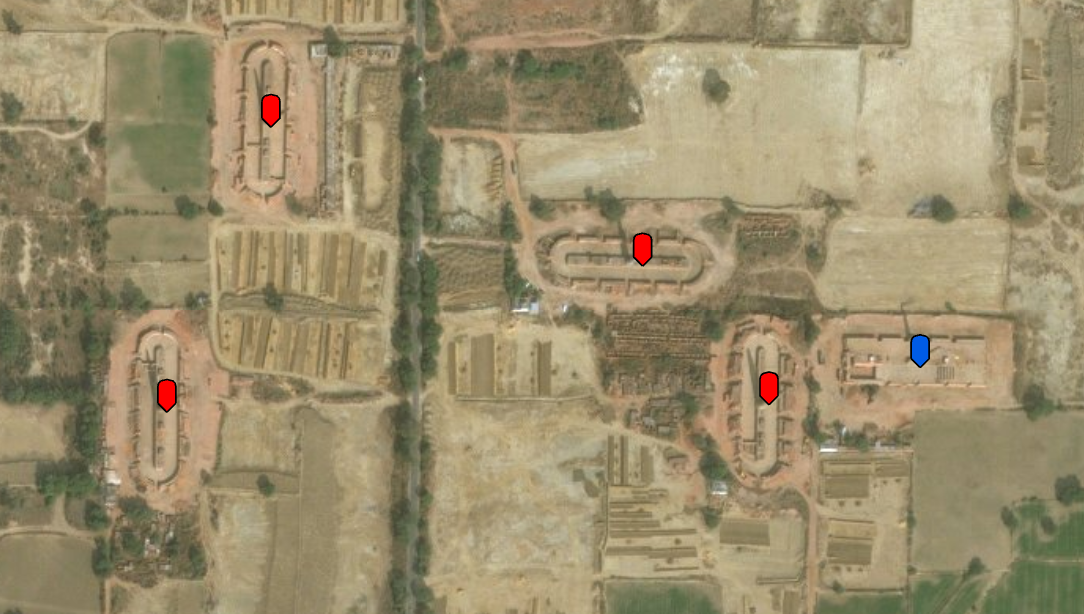

<center>A subset of training data.</center>

On the above image we can see **Zig-Zag shaped brick kilns** (Blue Marker) and **oval shaped brick kilns** (Red Marker).
  

<br>
  
<br>

## Export Training Data

Training data can be exported by using the 'Export Training Data For Deep Learning' tool available in [ArcGIS Pro](#"https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm") as well as [ArcGIS Enterprise](#"https://developers.arcgis.com/rest/services-reference/export-training-data-for-deep-learning.htm").

- **Input Raster**: ESRI World Imagery 2019
- **Input Feature Class Or Classified Raster**: brick kilns layer
- **Class Value Field**: field containing **0** for oval shaped brick kiln and **1** for zig-zag shaped brick kiln
- **Buffer Radius**: 75 Meter
- **Tile Size X** & **Tile Size Y**: 480
- **Meta Data Format**: 'Pascal Visual Object Classes' as we are training an Object Detection Model which in this case is `SingleShotDetector`.
- In 'Environments' tab set an optimum 'Cell Size' which can accommodate two three brick kilns in a single tile. For this sample the tile size which we have chosen is **448 px**  so a cell size of **1 meter** will be good enough. 

Tool Reference for [ArcGIS Pro](#"https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm") and [ArcGIS Enterprise](#"https://developers.arcgis.com/rest/services-reference/export-training-data-for-deep-learning.htm")


<div>
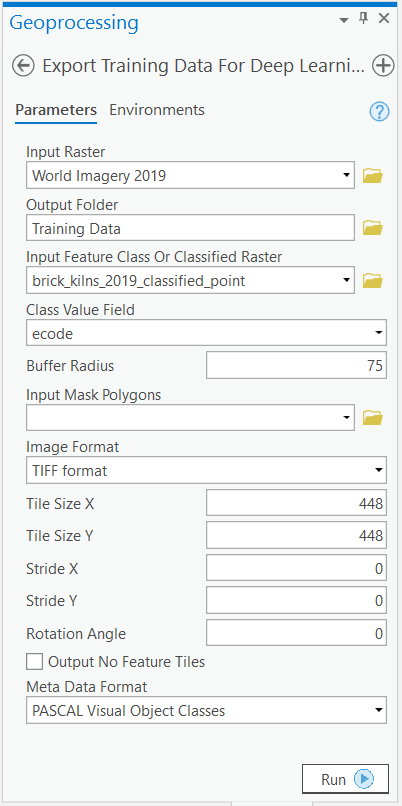
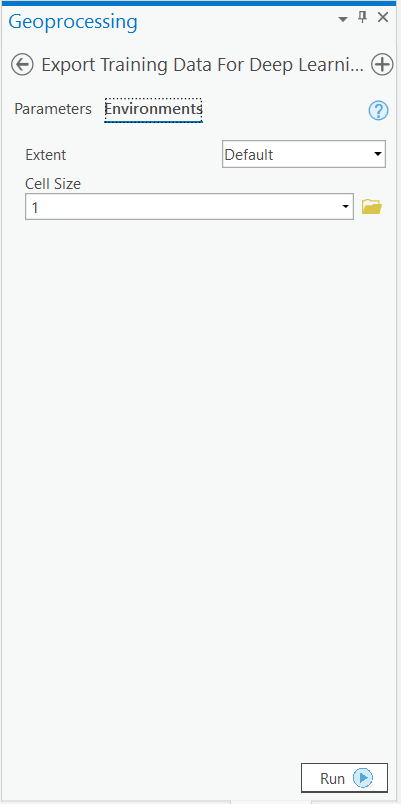
</div>

```python
arcpy.ia.ExportTrainingDataForDeepLearning("World Imagery 2019", r"C:\sample\Data\Training Data 448px 1m", "brick_kilns_2019_classified_point", , "TIFF", 448, 448, 0, 0, "ONLY_TILES_WITH_FEATURES", "PASCAL_VOC_rectangles", 0, "ecode", 75, None, 0)
```

After filling all details and running the Export Training Data For Deep Learning tool, a code like above will be generated and executed.  That will create all the necessary files needed for the next step in the 'Output Folder', and we will now call it our **training data**.

## Train the Model
We will train our model using `arcgis.learn` module within ArcGIS API for Python. `arcgis.learn` contains tools and deep learning capabilities required for this study. A detailed documentation to install and setup the environment is available [here](https://developers.arcgis.com/python/guide/install-and-set-up/).

### Necessary Imports

In [4]:
from arcgis.learn import SingleShotDetector, prepare_data

### Prepare Data

We will now use the `prepare_data()` function to apply various types of transformations and augmentations on the training data. These augemntations enables us to train a better model with limited data and also prevents the model from overfitting. `prepare_data()` takes 3 parameters.
<br>`path`: path of folder containing training data.
<br>`chip_size`: Same as per specified while exporting training data.
<br>`batch_size`: No of images your model will train on each step inside an epoch, it directly depends on the memory of your graphic card and the type of model which you are working with. For this sample **64** worked for us on a GPU with 11GB memory.

This function will return us a fastai databunch, we will use this in next step to train a model.

In [9]:
data = prepare_data(path=r'data\training data 448px 1m',
                    chip_size=448, 
                    batch_size=64)

#### Visualize a few samples from your Training data
To make sense of training data we will use the `show_batch()` method in `arcgis.learn`. `show_batch()` randomly picks few samples from the training data and visualizes those with the same symbology as in ArcGIS Pro.

`rows`: No of rows we want to see the results for.

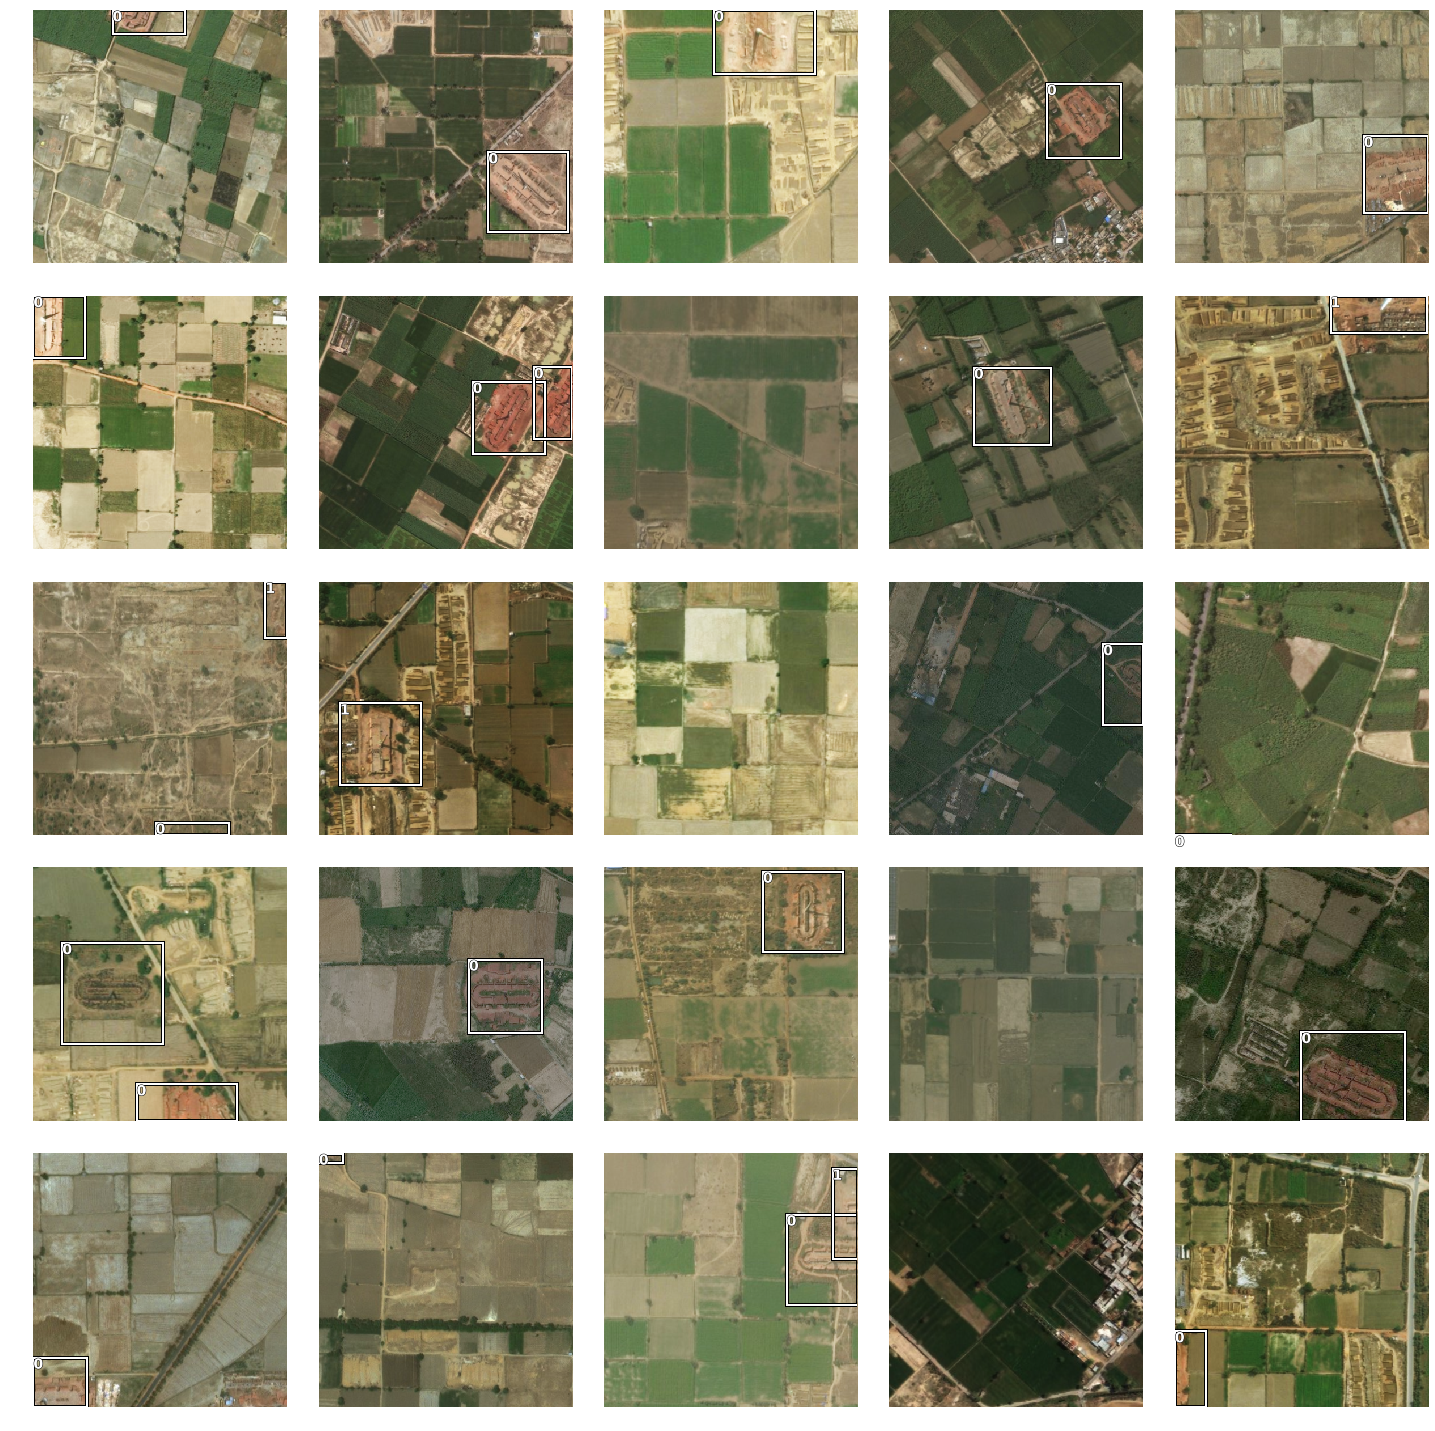

In [8]:
data.show_batch(rows=5)

<center>Some random samples from our training data have been visualized above.</center>

The imagery tiles above have been overlayed by bounding boxes of brick kilns, the boxes with 0 as label are oval shaped brick kilns and the ones with 1 as label are zig-zag shaped brick kilns.

### Load an SingleShotDetector model

The Code below will create a `SingleShotDetector` model, it is based on a state of art deep learning model architecture 'SSD'. The output from the model returns the bounding box of detected features. This type of model is used where '**object detection**' or in GIS terminology '**feature extraction**' is needed, by default this model will be loaded on a pretrained 'resnet' backbone. 

In [22]:
model = SingleShotDetector(data)

### Find an Optimal Learning Rate

Deep learning models are optimized by tuning these hyperparameters. A hyperparameter is a parameter whose value is set before the learning process begins [3]. Learning rate is a key parameter that determines how we adjust weights for our network with respect to loss gradient [4]. In this step we will find an optimum learning rate for our model on the training data, while training our model it will see the training data several times and adjust itself (the weights of the network). Too high learning rate will lead to the convergence of our model to an suboptimal solution and too low learning can slow down the convergence of our model. We can use the `lr_find()` method to find an optimum learning rate at which can train a robust model fast enough. 


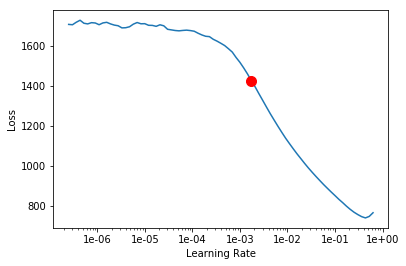

0.001737800828749376

In [5]:
model.lr_find()

Based on the learning rate plot above, we can see that the learning rate suggested by lr_find() for our training data is 1e-03.

### Fit the model

Epoch defines how many times model is exposed to entire training set. To start, we will use 10 epochs to train our model.


In [5]:
model.fit(epochs=10, lr=0.001)

Training data is split into training set and validation set at the [Prepare Data step](#Prepare-Data). By default training vs validation set proportion is 80% & 20%. Output of `fit()` method gives us loss on training and validation sets. This helps us to assess the generalization capability of the model on unseen data and prevent overfitting. Here, with only 10 epochs, we are see reasonable results. Further improvement can be achieved through more sophisticated hyperparameter tuning.

Next step is to save the model for further training or inference later. By default, model will be saved into data path specified in the beginning of this notebook.

### Save the model

We will save the model which we trained as a '**Deep Learning Package**' or '.dlpk' format. Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the `save()` method to save the model and by default it will be saved to a folder '**models**' inside our training data folder itself.

In [1]:
model.save('ssd_brick-kiln_01')

### Load an Intermediate model to train it further

To retrain a saved model, we can load it again using the code below and follow the steps as mentioned in [Fit the model step](#Fit-the-model).

In [23]:
# model.load('ssd_brick-kiln_01')

### Visualize results in validation set

Its a good practice to see results of the model viz-a-viz Ground Truth. Code below picks a random samples and shows us ground truth and model predictions, side by side. This enables us to preview the results of the model within the notebook.

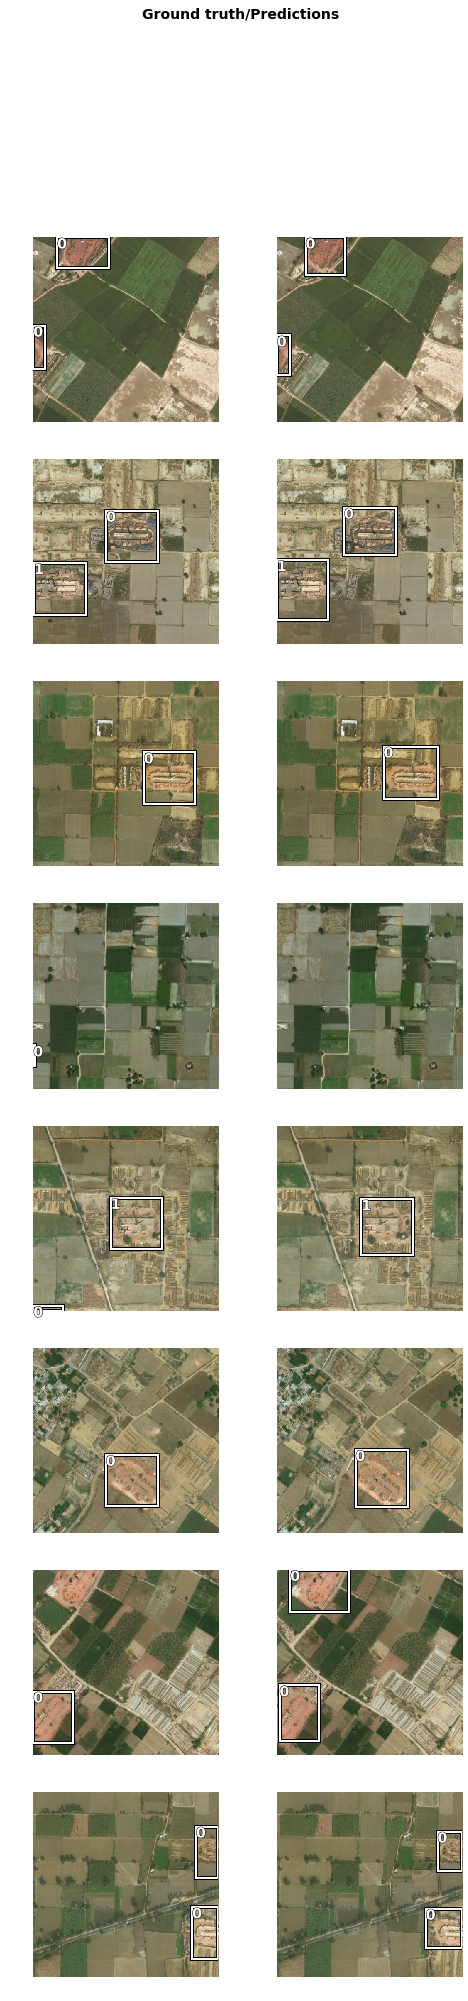

In [24]:
model.show_results(rows=8, thresh=0.2)

Here a subset of ground truth from training data have visualized along with the predictions from the model, as we can see above our model is performing well and the predictions are comparable to the ground truth.


## Deploy Model and Detect Brick Kilns

We will use saved model to extract classified raster using '**Detect Objects Using Deep Learning**' tool available in both [**ArcGIS Pro**](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/detect-objects-using-deep-learning.htm) and [**ArcGIS Enterprise**](https://developers.arcgis.com/rest/services-reference/detect-objects-using-deep-learning.htm). For this sample we will use ESRI World Imagery basemap and for a comparative analysis we will also detect brick kilns on an older [ESRI world imagery layer from year 2014](https://www.arcgis.com/home/item.html?id=903f0abe9c3b452dafe1ca5b8dd858b9) which we found using the [wayback imagery tool](https://livingatlas.arcgis.com/wayback/).

- **Input Raster**: ESRI World Imagery
- **Output Detect Objects**: brick_kilns_prediction_2014
- **Model Definition**: model.emd
- **padding**: The 'Input Raster' is tiled and the deep learning model classifies each individual tile separately before producing the final 'Output Classified Raster'. This may lead to unwanted artifacts along the edges of each tile as the model has little context to predict accurately. Padding as the name suggests allows us to supply some extra information along the tile edges, this helps the model to predict better. 
- **threshold**:0.1
- **nms_overlap**: 0.1
- **Cell Size**: Should be close to at which we trained the model, we specified that at the [Export Training Data step]("#Export-Training-Data") .


Tool Reference [here](#"https://pro.arcgis.com/en/pro-app/tool-reference/raster-analysis/detect-objects-using-deep-learning.htm")


<div>
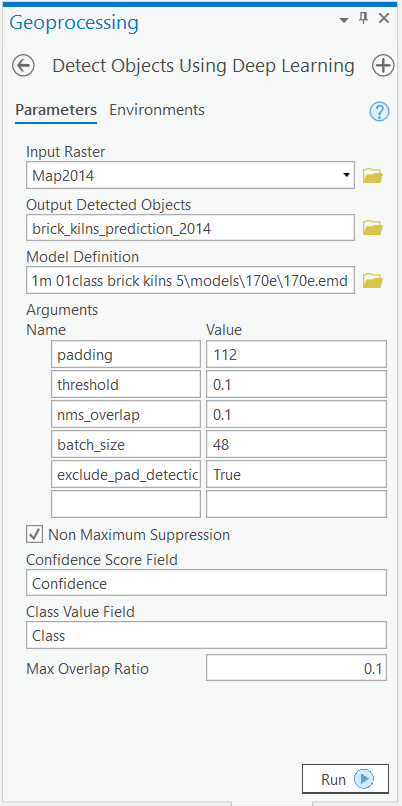
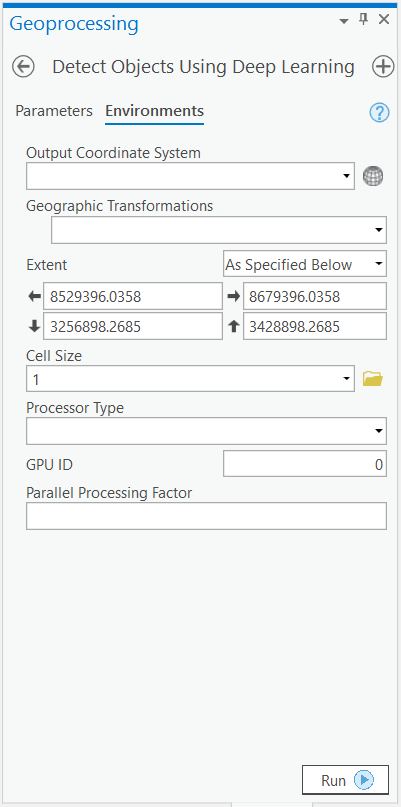
</div>

```python
arcpy.ia.DetectObjectsUsingDeepLearning("Imagery", r"C:\sample\sample.gdb\brick_kilns_prediction_2014", r"C:\sample\data\training data 448px 1m\models\best_model\best_model.emd", "padding 112;threshold 0.1;nms_overlap 0.1;batch_size 48;exclude_pad_detections True", "NO_NMS", "Confidence", "Class", 0)
```


`Detect Objects Using Deep Learning` returns a feature class that can be further refined using the [Definition query](https://pro.arcgis.com/en/pro-app/help/mapping/layer-properties/definition-query.htm) and [Non Maximum Suppression tool](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/non-maximum-suppression.htm) tool. This can also be shared as hosted feature layer in your Portal.

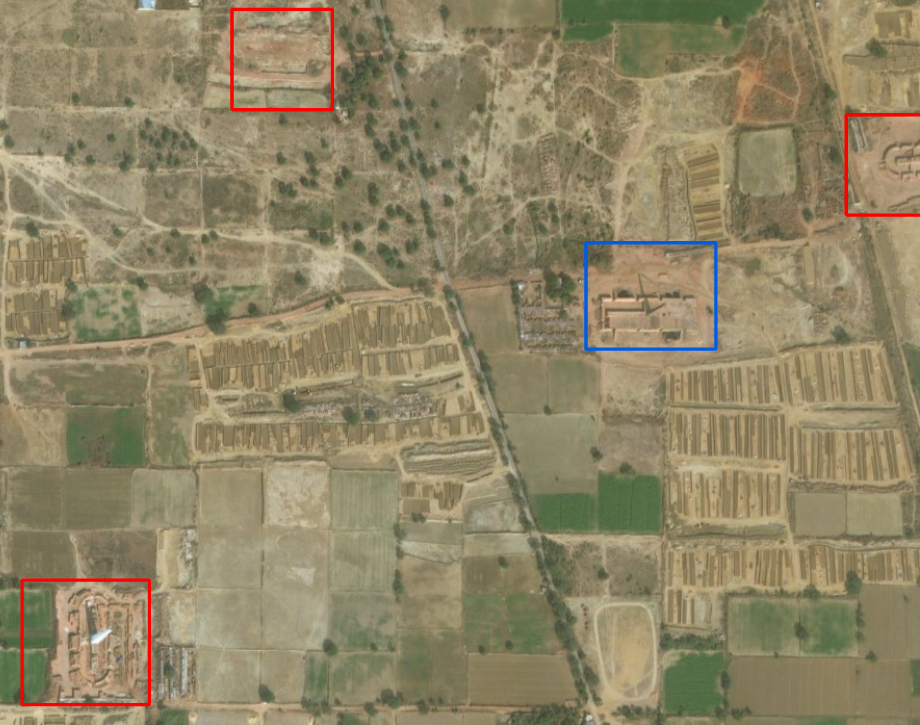

<center>A subset of detected Brick Kilns.</center>

### Conclusion

This type of workflows can be used by enforcement agencies to continuously track and monitor the implementation of law and order on ground. This will help the enforcement agencies to detect gaps in enforcement and better plan their actions.

#### An example of ArcGIS dashboard tracking Brick Kilns

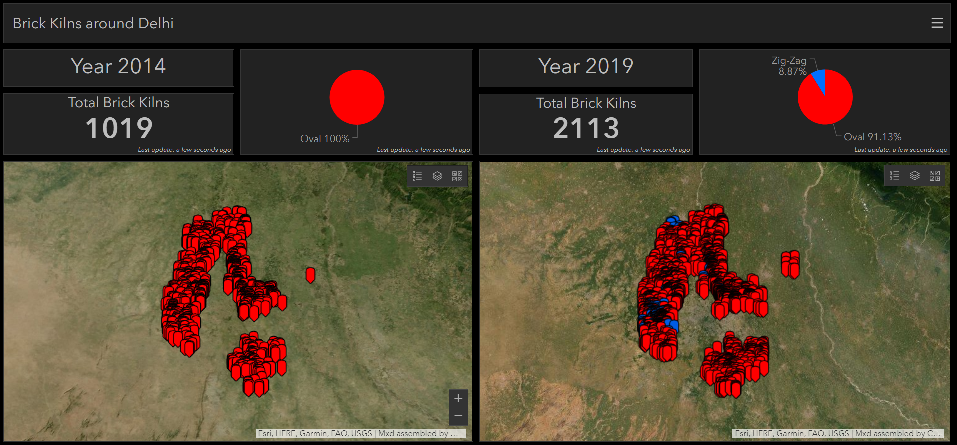

## References




[1] Sheikh, Afeefa. (2014). Brick kilns: Cause of Atmospheric Pollution. 

[2] https://www.cseindia.org/content/downloadreports/9387

[3] https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)

[4] https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10